In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exercise Classification

 - Import aps_failure_training_set.csv file and aps_failure_test_set.csv

 - Using training dataset, train a NN to predict the class. It indicates if there is failure in the trucks.

 - When using common accuracy metrics we know if our model is good, but is it good enough? We will define a new specific metric for this problem: Total cost. For each truck we say it fails the company sends a mecanic to review the truck, which supposes a cost of 10. On the other hand, if we say there is not failure when they actually are, the truck breakdowns, which supposes a cost of 500. In summary, False positives cost 10, and False negatives cost 500.

 - Train several NN and keep the one with less total costs.

 - The evaluation phase (Total cost calculation) must be done using the test dataset (aps_failure_test_set.csv)

In [2]:
import pandas as pd
import numpy as np # for data manipulation

# Sklearn
from sklearn.linear_model import LinearRegression # for building a linear regression model
from sklearn.svm import SVR, SVC # for building SVR model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder


# Visualizations
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
import plotly
import plotly.graph_objs as go

from tabulate import tabulate
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Advanced Data Analytics UAX-20231025T214223Z-001/Advanced Data Analytics UAX/data/3.-MLP/aps_failure_training_set.csv', sep=',')

data.fillna(data.mean(), inplace=True)

data['class'] = data['class'].replace({'neg': 0, 'pos': 1})

data.head()


<ipython-input-3-7e272f32f19b>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
#utilizamos la biblioteca Plotly para crear un gráfico de barras que muestra el porcentaje de valores nulos
#en cada característica (columna) del DataFrame data que excede un umbral dado (NULL_RATIO_TRHESHOLD)

NULL_RATIO_TRHESHOLD = 0 # Set the null ratio threshold required

null_ratios = (data.isnull().sum() / data.shape[0])
null_ratios_over_threshold = null_ratios[null_ratios > NULL_RATIO_TRHESHOLD].sort_values(ascending=False)

data_go = [
    go.Bar(
        x=null_ratios_over_threshold.index,
        y=null_ratios_over_threshold
    )
]

fig = go.Figure(data=data_go, layout={
    "title": "Null Ratio for Features with Null Ratio Exceeding {}".format(NULL_RATIO_TRHESHOLD)
})

plotly.offline.iplot(fig)

In [5]:
null_ratios_over_threshold = null_ratios[null_ratios > NULL_RATIO_TRHESHOLD].sort_values(ascending=False)
nan_columns = list(null_ratios_over_threshold[null_ratios_over_threshold>0.1].index)

In [6]:
X_train=data.iloc[:20000,1:]
y_train=data.iloc[:20000,0].astype(int)

X_train.head(3)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0


In [7]:
data_val = pd.read_csv('/content/drive/MyDrive/Advanced Data Analytics UAX-20231025T214223Z-001/Advanced Data Analytics UAX/data/3.-MLP/aps_failure_test_set.csv', delimiter=',')
data_val.loc[data_val['class'] == 'neg', 'class1'] = 0
data_val.loc[data_val['class'] == 'pos', 'class1'] = 1
data_val.drop('class', axis=1, inplace = True)
data_val.head(3)

data_val.drop(nan_columns, axis = 1, inplace = True)
for d in data_val.columns:
  data_val[d] = data_val[d].fillna(data_val[d].mean())

X_test = data_val.iloc[:,0:-1]
y_test = data_val.iloc[:,-1]


In [8]:
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X_train, y_train)

In [9]:
scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

val_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(val_sc)
X_test_sc.columns = X_test.columns

print(X_train_sc.shape)
print(X_test_sc.shape)


(39262, 170)
(16000, 170)


In [10]:
MLP_Clas = Sequential()
MLP_Clas.add(Dense(340, input_shape=(170,), activation='relu', kernel_regularizer=l1(0.01)))

MLP_Clas.add(Dense(170, activation='relu', kernel_regularizer=l1(0.01)))
MLP_Clas.add(Dropout(0.2))


MLP_Clas.add(Dense(1, activation='sigmoid', kernel_regularizer=l1(0.01)))

# Learning rate and optimizer
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# compile the keras model
MLP_Clas.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# fit the keras model on the dataset
history_Reg = MLP_Clas.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=20, batch_size=200)

# evaluate the keras model
_, accuracy= MLP_Clas.evaluate(X_train_sc, y_train)
_, accuracy2 = MLP_Clas.evaluate(X_test_sc, y_test)
print('Accuracy train: %.2f' % (accuracy))
print('Accuracy test: %.2f' % (accuracy2))

Epoch 1/20
197/197 [==============================] - 8s 7ms/step - loss: 12.7815 - accuracy: 0.9168 - val_loss: 0.5597 - val_accuracy: 0.9630
Epoch 2/20
197/197 [==============================] - 1s 5ms/step - loss: 0.5691 - accuracy: 0.9393 - val_loss: 0.4953 - val_accuracy: 0.9588
Epoch 3/20
197/197 [==============================] - 1s 5ms/step - loss: 0.5276 - accuracy: 0.9480 - val_loss: 0.4949 - val_accuracy: 0.9554
Epoch 4/20
197/197 [==============================] - 1s 6ms/step - loss: 0.5096 - accuracy: 0.9493 - val_loss: 0.4768 - val_accuracy: 0.9557
Epoch 5/20
197/197 [==============================] - 1s 7ms/step - loss: 0.4957 - accuracy: 0.9500 - val_loss: 0.4724 - val_accuracy: 0.9551
Epoch 6/20
197/197 [==============================] - 1s 7ms/step - loss: 0.4884 - accuracy: 0.9499 - val_loss: 0.4580 - val_accuracy: 0.9576
Epoch 7/20
197/197 [==============================] - 1s 5ms/step - loss: 0.4838 - accuracy: 0.9502 - val_loss: 0.4633 - val_accuracy: 0.9566
Epoch

In [11]:
predictions = MLP_Clas.predict(X_test_sc, verbose = 0).round(0)
conf_mat = confusion_matrix(y_test, predictions)
print(tabulate(conf_mat,headers = ['pred neg','pred pos'], showindex = ['real neg','real pos'],
               tablefmt = 'fancy_grid'))

print(classification_report(y_test, predictions))

print("Total cost: {}".format((conf_mat[1][0] * 500 + conf_mat[0][1] * 10) / X_test_sc.shape[0]))

╒══════════╤════════════╤════════════╕
│          │   pred neg │   pred pos │
╞══════════╪════════════╪════════════╡
│ real neg │      14981 │        644 │
├──────────┼────────────┼────────────┤
│ real pos │         17 │        358 │
╘══════════╧════════════╧════════════╛
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     15625
         1.0       0.36      0.95      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.96      0.75     16000
weighted avg       0.98      0.96      0.97     16000

Total cost: 0.93375


## Exercise Regression

 - Import medical_score_train.csv and medical_score_test.csv

 - Using training dataset, train a NN for medical score prediction

In [12]:
df=pd.read_csv('/content/drive/MyDrive/Advanced Data Analytics UAX-20231025T214223Z-001/Advanced Data Analytics UAX/data/3.-MLP/medical_score_train.csv', delimiter=';')
df=df.drop(columns=['Id'], axis=0)

X=df.iloc[:,1:-1]
y=df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)
print(X_train.shape)
print(y_train.shape)

scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

val_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(val_sc)
X_test_sc.columns = X_test.columns


df2=pd.read_csv('/content/drive/MyDrive/Advanced Data Analytics UAX-20231025T214223Z-001/Advanced Data Analytics UAX/data/3.-MLP/medical_score_test.csv', delimiter=',')
X_test2=df2.drop(columns=['Id'])


(3726, 26)
(3726,)


In [13]:
NULL_RATIO_TRHESHOLD = 0 # Set the null ratio threshold required

null_ratios = (df.isnull().sum() / df.shape[0])
null_ratios_over_threshold = null_ratios[null_ratios > NULL_RATIO_TRHESHOLD].sort_values(ascending=False)

data_go = [
    go.Bar(
        x=null_ratios_over_threshold.index,
        y=null_ratios_over_threshold
    )
]

fig = go.Figure(data=data_go, layout={
    "title": "Null Ratio for Features with Null Ratio Exceeding {}".format(NULL_RATIO_TRHESHOLD)
})

plotly.offline.iplot(fig)

Epoch 1/32
746/746 [==============================] - 7s 7ms/step - loss: 10.2662 - val_loss: 8.8043
Epoch 2/32
746/746 [==============================] - 5s 6ms/step - loss: 8.5654 - val_loss: 8.6780
Epoch 3/32
746/746 [==============================] - 3s 4ms/step - loss: 8.3029 - val_loss: 8.4914
Epoch 4/32
746/746 [==============================] - 4s 6ms/step - loss: 8.1640 - val_loss: 8.4576
Epoch 5/32
746/746 [==============================] - 5s 6ms/step - loss: 8.1132 - val_loss: 8.7235
Epoch 6/32
746/746 [==============================] - 2s 3ms/step - loss: 7.9943 - val_loss: 8.3684
Epoch 7/32
746/746 [==============================] - 2s 3ms/step - loss: 7.8817 - val_loss: 8.2118
Epoch 8/32
746/746 [==============================] - 3s 3ms/step - loss: 7.7885 - val_loss: 8.2945
Epoch 9/32
746/746 [==============================] - 3s 5ms/step - loss: 7.6549 - val_loss: 8.4302
Epoch 10/32
746/746 [==============================] - 2s 3ms/step - loss: 7.5753 - val_loss: 7.951

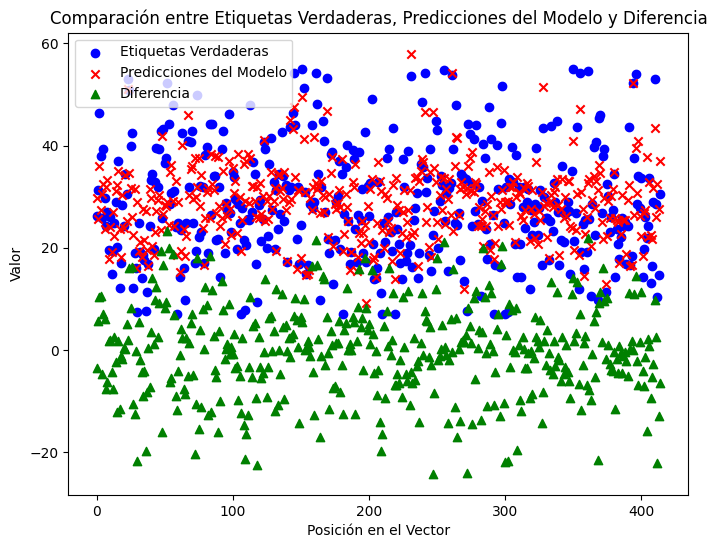

In [18]:
model = Sequential()
model.add(Dense(64, input_shape=(26,), kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compilamos el modelo

model.compile(loss='mae', optimizer='adam')
model.fit(X_train_sc, y_train, epochs=32, batch_size=5, validation_data=(X_test_sc, y_test))

pred = model.predict(X_test_sc)
print("MAE: ", metrics.mean_absolute_error(y_test, pred).round(4))

import matplotlib.pyplot as plt

# Suponiendo que y_test son las etiquetas verdaderas y predictions son las predicciones del modelo
plt.figure(figsize=(8, 6))

print(y_test.shape, pred.shape)
# Calcula la diferencia entre las etiquetas verdaderas y las predicciones
diferencia = y_test - pred.reshape(-1)

# Crea un gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Etiquetas Verdaderas', marker='o')
plt.scatter(range(len(pred)), pred, color='red', label='Predicciones del Modelo', marker='x')
plt.scatter(range(len(diferencia)), diferencia, color='green', label='Diferencia', marker='^')

plt.xlabel('Posición en el Vector')
plt.ylabel('Valor')
plt.title('Comparación entre Etiquetas Verdaderas, Predicciones del Modelo y Diferencia')
plt.legend()
plt.show()

In [19]:
!pip install scikeras

Estandarizado: -7.64 (0.18) MAE
Error Cuadrático Medio (MAE) en los datos de prueba: 7.29


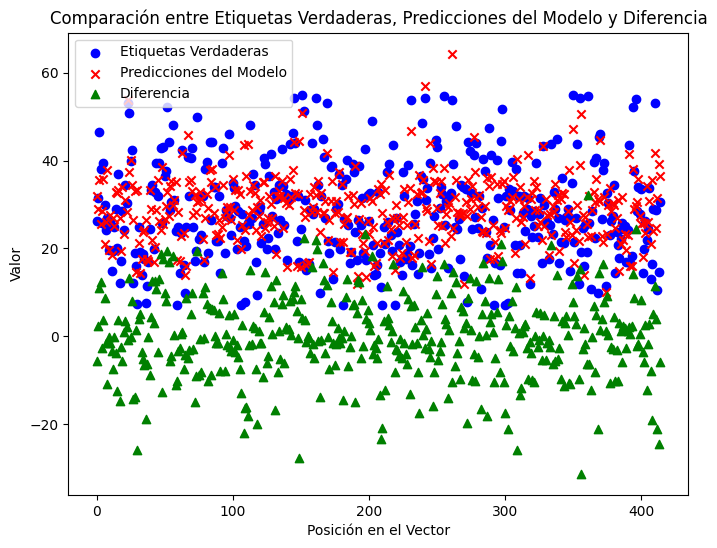

In [24]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

def modelo_ancho():
  # creamos el modelo
  model = Sequential()
  model.add(Dense(64, input_shape=(26,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(128, kernel_initializer='normal', activation='relu'))
  model.add(Dense(128, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  # compilamos el modelo
  model.compile(loss='mae', optimizer='adam')
  return model

# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=modelo_ancho, epochs=32, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')# en regresion lineal el scoring en lugar de ser la precision, es la propia funcion de perdida
print("Estandarizado: %.2f (%.2f) MAE" % (results.mean(), results.std()))

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

# Calcula el error cuadrático medio en las predicciones
mae = mean_absolute_error(y_test, predictions)
print("Error Cuadrático Medio (MAE) en los datos de prueba: {:.2f}".format(mae))

import matplotlib.pyplot as plt

# Suponiendo que y_test son las etiquetas verdaderas y predictions son las predicciones del modelo
plt.figure(figsize=(8, 6))

# Calcula la diferencia entre las etiquetas verdaderas y las predicciones
diferencia = y_test - predictions

# Crea un gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Etiquetas Verdaderas', marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicciones del Modelo', marker='x')
plt.scatter(range(len(diferencia)), diferencia, color='green', label='Diferencia', marker='^')

plt.xlabel('Posición en el Vector')
plt.ylabel('Valor')
plt.title('Comparación entre Etiquetas Verdaderas, Predicciones del Modelo y Diferencia')
plt.legend()
plt.show()